# Bayesian analysis of the empirical saturation point (refactored version)

In [6]:
from modules.DataSets import GenericDataSet, NormDistDataSet, KernelDensityEstimate
from modules.EftPredictions import *
from modules.StatisticalModel import StatisticalModel
import matplotlib.backends.backend_pdf
from tqdm import tqdm

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set the location where pdf output will be stored.

In [8]:
import os
pdf_path = "./pdf"
if not os.path.exists(pdf_path):
    os.mkdir(pdf_path)

## Constraints from density functional theory: data management

In [17]:
dft_constraints = {
    "Dutra_skyrme": GenericDataSet(filenames=["satpoints_dutra_skyrme.csv"]),
    "Kortelainen": GenericDataSet(filenames=["satpoints_kortelainen.csv"]),
    "Brown": GenericDataSet(filenames=["brown/satpoints_brown.csv"]),
    "Dutra_rmf": GenericDataSet(filenames=["satpoints_rmf_dutra_2014.csv"]),
    "FSU": NormDistDataSet(set_specifier="fsu_rmf"),
    "Schunck": KernelDensityEstimate(set_specifier="schunck")
}
# now add the saturation box from Drischler et al. (2016)
drischler = dft_constraints["Dutra_skyrme"] + dft_constraints["Kortelainen"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


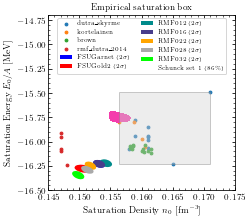

In [18]:
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{pdf_path}/refactored_overview.pdf")
fig, ax = plt.subplots(1, 1, figsize=(1.25*6.8*cm, 1.2*6.8*cm))
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)
pdf.savefig(fig)

for key, val in dft_constraints.items():
    val.plot(ax=ax)
    pdf.savefig(fig)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 40 seconds.


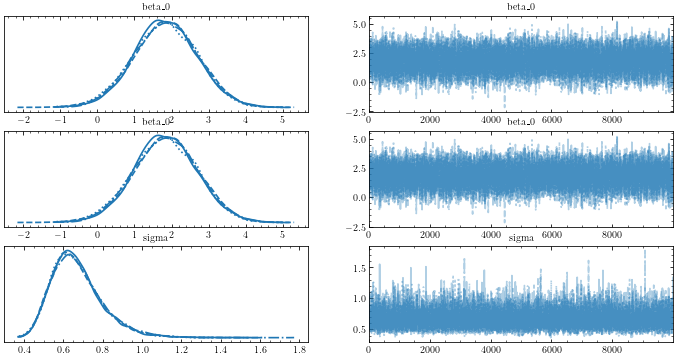

In [19]:
eft_pred = EftPredictions()
eft_pred.corner_plot()
eft_pred.plot(ax=ax)
pdf.savefig(fig)
pdf.close()

## Single universe as a test case

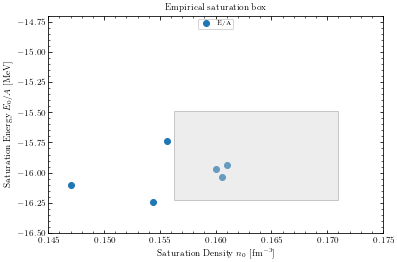

In [21]:
sampled_dft_constraints = pd.DataFrame()
for key, val in dft_constraints.items():
    sampled_dft_constraints = val.sample(df=sampled_dft_constraints)

ax = sampled_dft_constraints.plot(x="rho0", y="E/A", linestyle="None", marker="o")
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

In [9]:
sampled_dft_constraints  # one realization (aka "universe") for testing

,label,rho0,E/A,class,file
2,Ska25,0.16100,-16.070000,dutra_skyrme,satpoints_dutra_skyrme.csv
0,SLy4,0.16000,-15.972000,kortelainen,satpoints_kortelainen.csv
0,brown:1,0.16148,-16.114130,brown,brown/satpoints_brown.csv
1,BKA24,0.14700,-15.950000,rmf_dutra_2014,satpoints_rmf_dutra_2014.csv
0,RMF012,0.15398,-16.228985,fsu_rmf,data/Piekarewicz/RMF012/CovEllipse.com
4480,schunck:3,0.15531,-15.715748,schunck:3,data/Schunck/samples3.csv


In [22]:
prior_params = {"mu": np.array([0.16, -15.9]),
                "Psi": np.array([[0.01**2, 0], [0, 0.32**2]]),
                "kappa": 1, "nu": 4}  # TODO: this prior is way too uninformed for the "true" nuclear saturation point. Make it realistic.
spoint = StatisticalModel(data=sampled_dft_constraints,
                          quantities=["rho0", "E/A"],
                          prior_params=prior_params)
spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True)

sanity check based on predictive 'prior'
quantiles conj. prior: [[  0.14088003 -16.51103178]
 [  0.1599752  -15.89939909]
 [  0.17945053 -15.28056996]]
quantiles brute-force: [[  0.14068991 -16.51095574]
 [  0.15999076 -15.90053107]
 [  0.17935437 -15.28541781]]
passed: True


True

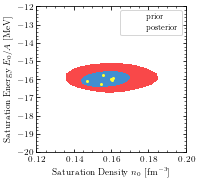

In [23]:
from modules.plot_helpers import *
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
spoint.plot(ax=ax, num_samples=500000)
fig.savefig(f"{pdf_path}/output.pdf")

## Multiple Universes
Now, let's average over different realizations ("universes").

Multi-universe sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [22:08<00:00, 265.79s/it]


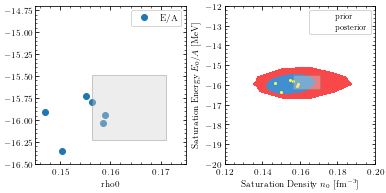

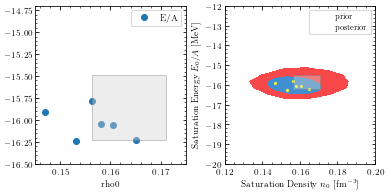

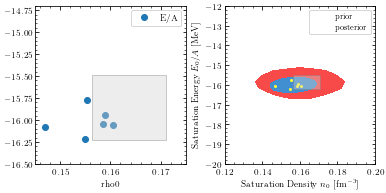

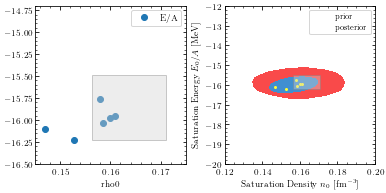

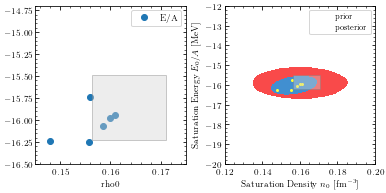

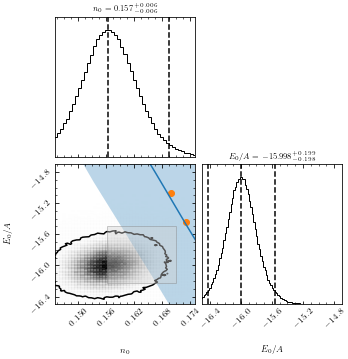

In [37]:
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{pdf_path}/multi_universe_output.pdf")
num_realizations = 5
samples = pd.DataFrame()

for irealiz in tqdm(range(num_realizations), desc="Multi-universe sampling"):
    # set up canvas
    fig, axs = plt.subplots(1, 2, figsize=(2*6.8*cm, 6.8*cm), constrained_layout=True)

    # construct data set ("universe") for Bayesian inference
    sampled_dft_constraints = pd.DataFrame()
    for key, val in dft_constraints.items():
        sampled_dft_constraints = val.sample(df=sampled_dft_constraints)

    # plot raw data (left panel)
    sampled_dft_constraints.plot(ax=axs[0], x="rho0", y="E/A", linestyle="None", marker="o")
    for ax in axs:  # draw saturation box in both panels as a reference
        drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True,
                       add_legend=False, add_axis_labels=False)
    axs[0].set_xlim(0.145, 0.175)
    axs[0].set_ylim(-16.5, -14.7)

    # perform Bayesian analysis
    spoint = StatisticalModel(data=sampled_dft_constraints,
                              quantities=["rho0", "E/A"],
                              prior_params=prior_params)
    #print(spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True))

    # store data from current universe (for universe-averaging later on)
    tmp = spoint.sample_predictive_bf(return_predictive_only=False, based_on="posterior",
                                      num_samples=1, num_samples_mu_Sigma=100000)  # 100000
    tmp["universe"] = irealiz
    samples = pd.concat((samples, tmp))

    # plot predictive prior and predictive posterior (right panel)
    spoint.plot(ax=axs[1], num_samples=500000)  #500000
    pdf.savefig(fig)

# plot multi-universe average of the posterior predictive
names = ["predictive rho0", "predictive E/A"]
labels = [r"$n_0$", r"$E_0/A$"]
n_std = 2 # e.g., 86% will correspond to 2 sigma in 2 dimensions
fig, axs = plt.subplots(2, 2, figsize=(2*6.8*cm, 2*6.8*cm))
corner.corner(samples, var_names=names, labels=labels,
              quantiles=(0.025, 0.5, 0.975),  # TODO: 2 sigma hard-coded
              title_quantiles=(0.025, 0.5, 0.975),
              levels=(1 - np.exp(-n_std**2 / 2),),
              bins=200,
              plot_datapoints=False, plot_density=True,
              show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 8}, fig=fig)
drischler.plot(ax=axs[1, 0], plot_scatter=False, plot_box_estimate=True,
               add_legend=False, add_axis_labels=False)
eft_pred.plot(ax=axs[1, 0])

axs[0, 0].set_xlim(0.145, 0.175)
axs[1, 0].set_xlim(0.145, 0.175)
axs[1, 0].set_ylim(-16.5, -14.7)
axs[1, 1].set_xlim(-16.5, -14.7)

pdf.savefig(fig)
pdf.close()

Let's take a look at the plain data from the different universes.

In [38]:
samples

,predictive rho0,predictive E/A,mu rho0,mu E/A,"Sigma (0,0)","Sigma (0,1)","Sigma (1,1)",universe
0,0.143892,-16.042639,0.154314,-15.861061,0.000039,0.000174,0.035090,0
1,0.161872,-16.400111,0.160705,-15.932884,0.000042,-0.000343,0.081829,0
2,0.166229,-16.160055,0.154712,-15.916205,0.000024,-0.000208,0.048252,0
3,0.154831,-16.006646,0.154203,-15.905837,0.000014,-0.000097,0.070777,0
4,0.147742,-16.306258,0.155126,-16.079118,0.000025,-0.000110,0.095353,0
...,...,...,...,...,...,...,...,...
99995,0.157412,-15.872726,0.158059,-16.066370,0.000033,0.001146,0.068887,4
99996,0.153379,-16.339057,0.154397,-16.032097,0.000021,0.000078,0.026579,4
99997,0.153701,-15.997642,0.157469,-16.052953,0.000011,0.000351,0.033137,4
99998,0.151062,-16.346234,0.157698,-16.071519,0.000118,0.001413,0.050989,4


Interesting! Look at the off-diagonal component of $\Sigma$, i.e., `Sigma (0,1)`. It's close to zero and changes sign. Why don't we obtain the saturation density and energy uncorrelated? Is that because of the chosen prior or prior paramaters?